## Null-Hypothesis Simulation - MCMC Burn-in

### Data Cleaning and Processing 

In [6]:
import ete3
import re
import os
import subprocess
import inflect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
with open("September_10_2019_Modified_Eight_Calibrations_Gene_PhyloBayes_Posterior_sample.datedist") as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [8]:
tree = ete3.Tree(content[0],format=1)

In [9]:
def Remove_Duplicate(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

In [10]:
leaf_list = []
for leaf in tree.get_leaves():
    leaf_list.append(leaf.name)

In [11]:
leaf_node_list = []
for node in tree.traverse():
    if node.is_leaf():
        leaf_node_list.append(node.name)

In [12]:
def node_age_on_each_tree(tree):
    leaf_node_list = []
    internal_age_list = []
    for node in tree.traverse():
        if node.is_leaf():
            leaf_node_list.append(node.name)
        else:
            internal_age_list.append(node.name)
    return  internal_age_list 

In [13]:
All_Sample_Age_List = []
for i in range (0, len(content)):
    tree = ete3.Tree(content[i],format=1)
    One_Age_List = node_age_on_each_tree(tree)
    All_Sample_Age_List.append(One_Age_List)
df=pd.DataFrame(All_Sample_Age_List)

In [14]:
# Take the first 3829 trees from the solution space of tress; 
# The index in "[]" can be changed for different "burn-in" we want.
df_list_1  = df[0:3840] 
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]

# Change the ages in the list to negative numbers# Divide the number of nodes in each bin (corresponding to the )
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])

### Divergence of Node Numbers in Each Bin (NOT Cumulative Number of Nodes)

In [15]:
bin_size = 100

In [16]:
his_data_eight_calibration_1 = np.histogram(negative_age_list_1, bins=3000/bin_size, range = (-3000, 0))
age_interval_list = his_data_eight_calibration_1[1]
age_interval_list = age_interval_list.tolist()
middle_age_interval_list = [left_age + (bin_size/float(2)) for left_age in age_interval_list]
del middle_age_interval_list[-1]
middle_age_interval_list

node_number_each_interval = his_data_eight_calibration_1[0]
node_number_each_interval = node_number_each_interval.tolist()

In [17]:
# Divide node number in each bin by the total number of trees
# Let's call this "normalized node number in a bin" 
node_number_each_interval_normalized_by_tree_number = [i / float(len(df_list_1)) for i in node_number_each_interval]

# Divide normalized node number in a bin by the bin size (that is, node number pre Myr)
# Let's call this "normalized node density"
node_density_each_interval_normalized_by_tree_number = [i / float(bin_size) for i in node_number_each_interval_normalized_by_tree_number]

In [18]:
# The average omega here is calculated from theroectial formula: average omega = (log(N2)-log(N1))/t, 
# where t is bin_size. The average_omega is calculated from the two end points when t = 
#-2950 (i.e. -3000Ma + 50 Ma) and t = -50 Ma; actually, 50 Ma = 0.5 * bin_size.
noncumulative_density_avergae_omega = (np.log(node_number_each_interval_normalized_by_tree_number[-1]) - np.log(node_number_each_interval_normalized_by_tree_number[0])) / float(3000-bin_size)
noncumulative_density_avergae_omega

0.0013527777676541665

In [19]:
# Take the logarithm of each  "normalized node density"
log_node_density_each_interval_normalized_by_tree_number = [np.log(i) for i in node_density_each_interval_normalized_by_tree_number]

In [20]:
# Change the list of "middle point at each time interval" to an array
array_middle_age_interval_list = np.array(middle_age_interval_list)

# Change the list of "normalized node density" to an array
array_node_density_each_interval_normalized_by_tree_number = np.array(node_density_each_interval_normalized_by_tree_number)

In [21]:
# Data here are the slopes computed using SMA (alos called reduced major axis regresion) in "lmodel2" in R
slope_array = np.array([0.0004089477, 0.0010468298, 0.0004497527, 0.0030626575, 0.0008683399, 0.0034827923])

In [22]:
# Data here are the intercepts computed using SMA (alos called reduced major axis regresion) in "lmodel2" in R
intercept_array = np.array([-3.0483709, -1.3684021, -2.7591503,  0.6883361, -1.3923985, -0.1524506])

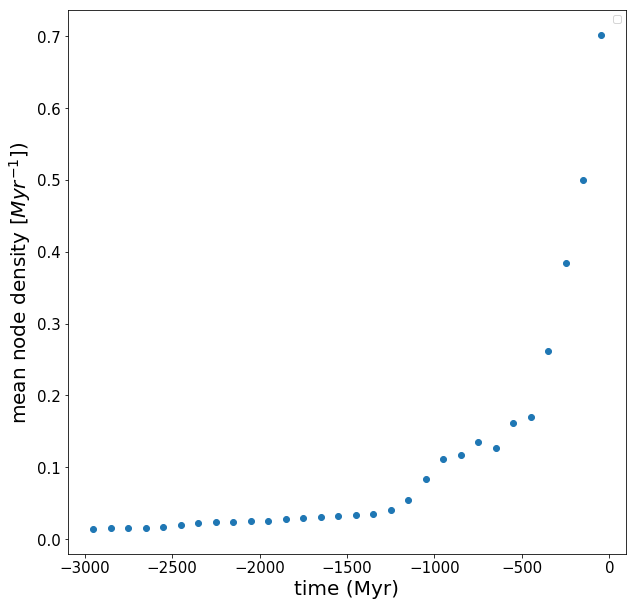

In [23]:
#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
ax.plot(array_middle_age_interval_list, node_density_each_interval_normalized_by_tree_number, 'o')
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('mean node density [$Myr^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('MeanNodeDensity.jpg', dpi=500)
plt.show()

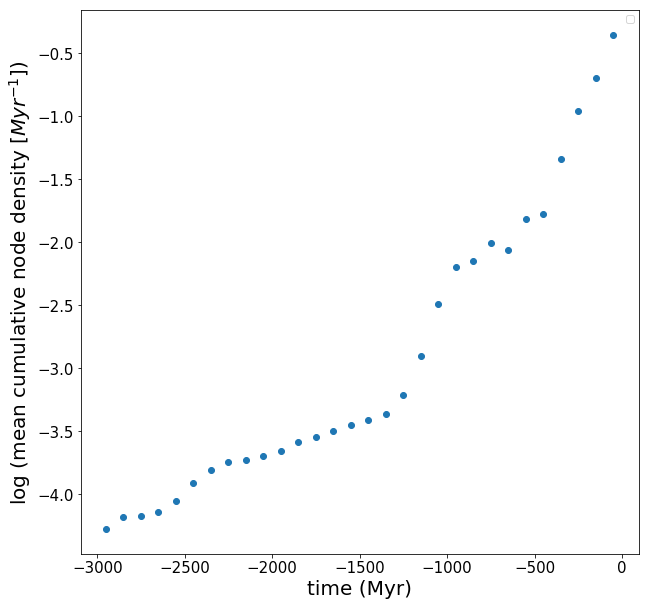

In [24]:
#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
ax.plot(array_middle_age_interval_list, log_node_density_each_interval_normalized_by_tree_number, 'o')
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('log (mean cumulative node density [$Myr^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('PiecewiseCumulativeLogFitting.jpg.jpg', dpi=500)
plt.show()

In [25]:
#definition of the piecewise fitting lines
def g_X(x):
    if x >= array_middle_age_interval_list[0] and x < array_middle_age_interval_list[3]:
        return  x * slope_array[0]  + intercept_array[0]
    elif x >= array_middle_age_interval_list[3] and x < array_middle_age_interval_list[7]:
        return  x * slope_array[1]  + intercept_array[1]
    elif x >= array_middle_age_interval_list[7] and x < array_middle_age_interval_list[16]:
        return  x * slope_array[2]  + intercept_array[2]
    elif x >= array_middle_age_interval_list[16] and x < array_middle_age_interval_list[20]:
        return  x * slope_array[3]  + intercept_array[3]
    elif x >= array_middle_age_interval_list[20] and x < array_middle_age_interval_list[25]:
        return  x * slope_array[4]  + intercept_array[4]
    elif x >= array_middle_age_interval_list[25] and x < array_middle_age_interval_list[29]:
        return  x * slope_array[5]  + intercept_array[5]
    else:
        pass

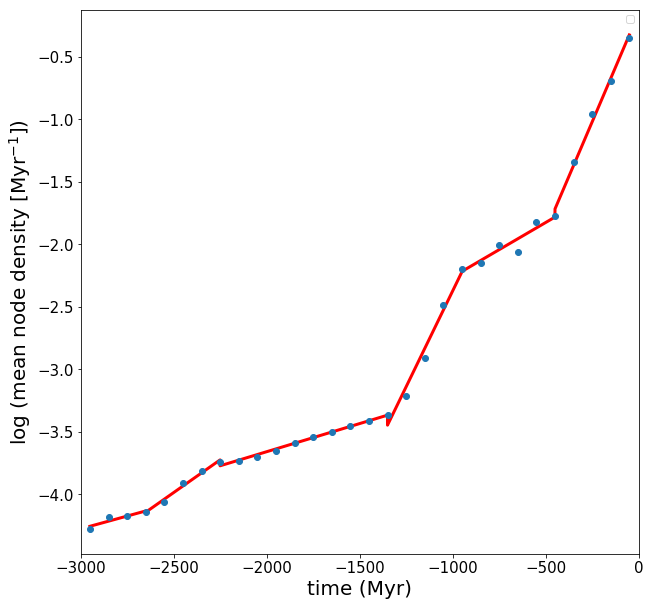

In [26]:
### vectorize f_X, so that it takes arrays and inputs!
g_X_vec = np.vectorize(g_X)

#visualize pdf
plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
plt.plot(x, g_X_vec(x), color='red', linewidth=3)
plt.plot(array_middle_age_interval_list, log_node_density_each_interval_normalized_by_tree_number , 'o')
plt.xlim(-3000, 0)
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('log (mean node density [Myr$^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('PiecewiseLogFitting.jpg.jpg', dpi=500)
plt.show()

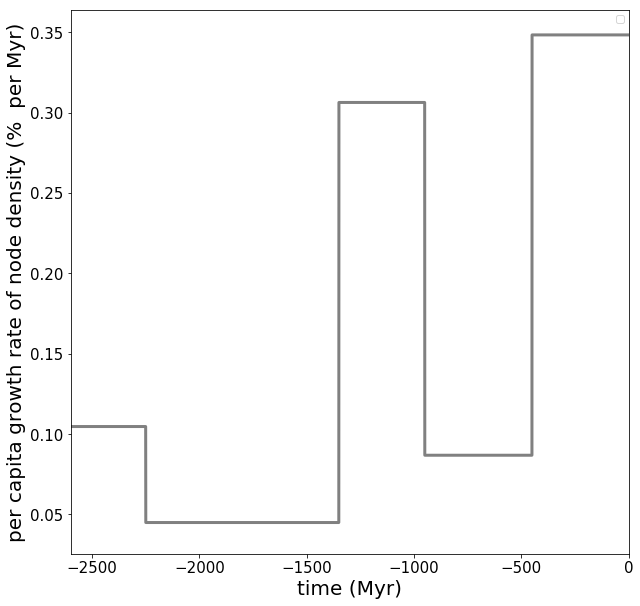

In [27]:
#definition of the pdf
def f_X(x):
    if x >= array_middle_age_interval_list[0] and x <= array_middle_age_interval_list[3]:
        return slope_array[0]
    elif x >= array_middle_age_interval_list[3] and x <= array_middle_age_interval_list[7]:
        return slope_array[1]
    elif x >= array_middle_age_interval_list[7] and x <= array_middle_age_interval_list[16]:
        return slope_array[2]
    elif x >= array_middle_age_interval_list[16] and x <= array_middle_age_interval_list[20]:
        return slope_array[3]
    elif x >= array_middle_age_interval_list[20] and x <= array_middle_age_interval_list[25]:
        return slope_array[4]
    else:
        return slope_array[5]


#vectorize f_X, so that it takes arrays and inputs!
f_X_vec = np.vectorize(f_X)


#visualize pdf
plt.figure(figsize=(10,10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 5000)
plt.plot(x, 100*f_X_vec(x), color='gray', linewidth=3)
plt.xlim(-2600, 0)
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('per capita growth rate of node density (%  per Myr)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('GrowthofLogNodeNumbers.jpg', dpi=500)
plt.show()

### Divergence of Cumulative Node Numbers in Each Bin

In [28]:
df_list_1  = df[0:3840]
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])
his_data_eight_calibration_1 = np.histogram(negative_age_list_1, bins=3000/bin_size, range = (-3000, 0))

Divergence_number_in_bin_eight_calibration = his_data_eight_calibration_1[0]

# Calculate cumulative number of nodes
cumulative_divergence_number = np.cumsum(Divergence_number_in_bin_eight_calibration) 
cumulative_divergence_number = cumulative_divergence_number.tolist()

In [29]:
cumulative_node_number_each_interval_normalized_by_tree_number =  [i / float(len(df_list_1)) for i in cumulative_divergence_number]
cumulative_node_density_each_interval_normalized_by_tree_number = [i / float(bin_size) for i in cumulative_node_number_each_interval_normalized_by_tree_number]
log_cumulative_node_density_each_interval_normalized_by_tree_number = [np.log(i) for i in cumulative_node_density_each_interval_normalized_by_tree_number]
np.array(log_cumulative_node_density_each_interval_normalized_by_tree_number)

array([-4.27710371, -3.53455022, -3.11033677, -2.80588701, -2.55442421,
       -2.32504907, -2.12093651, -1.94085783, -1.78658538, -1.64879614,
       -1.52281832, -1.40328158, -1.29194108, -1.18779363, -1.08890951,
       -0.99527335, -0.90576688, -0.81106304, -0.69497698, -0.54107008,
       -0.36612421, -0.2103803 , -0.05634992,  0.0695212 ,  0.21046772,
        0.33947183,  0.5105287 ,  0.71798968,  0.93621386,  1.17931584])

In [30]:
# The average omega here is calculated from theroectial formula: average omega = (log(N2)-log(N1))/t, 
# where t is bin_size. The average_omega is calculated from the two end points when t = 
#-2950 (i.e. -3000Ma + 50 Ma) and t = -50 Ma; actually, 50 Ma = 0.5 * bin_size.
cumulative_density_avergae_omega = (np.log(cumulative_node_number_each_interval_normalized_by_tree_number[-1]) - np.log(cumulative_node_number_each_interval_normalized_by_tree_number[0])) / float(3000-bin_size)
cumulative_density_avergae_omega

0.0018815239828891953

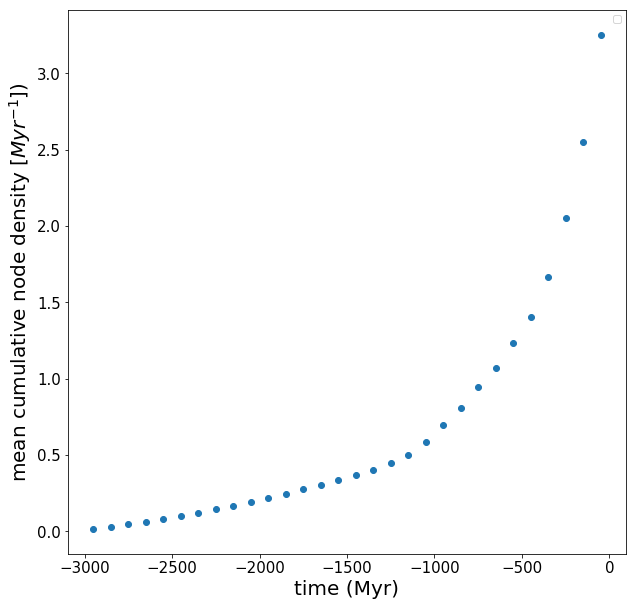

In [31]:
#vectorize f_X, so that it takes arrays and inputs!
g_X_vec = np.vectorize(g_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
#ax.plot(x, g_X_vec(x), color='red', linewidth=3)
ax.plot(array_middle_age_interval_list, cumulative_node_density_each_interval_normalized_by_tree_number, 'o')
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('mean cumulative node density [$Myr^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('MeanCumulativeNodeDensity.jpg', dpi=500)
plt.show()

In [32]:
log_cumulative_node_density_each_interval_normalized_by_tree_number

[-4.277103714747103,
 -3.5345502188000864,
 -3.110336772365046,
 -2.805887007641296,
 -2.5544242124727354,
 -2.325049071044603,
 -2.120936505648798,
 -1.940857829377085,
 -1.7865853779543257,
 -1.6487961350413733,
 -1.5228183222523446,
 -1.4032815803992396,
 -1.2919410783895144,
 -1.1877936319689495,
 -1.0889095132067246,
 -0.9952733462632406,
 -0.9057668753367704,
 -0.8110630375366898,
 -0.6949769786198057,
 -0.5410700776795958,
 -0.36612420986970745,
 -0.21038029719104823,
 -0.05634991723201842,
 0.069521204116907,
 0.21046771798453967,
 0.33947182561452727,
 0.5105287046898843,
 0.717989680290662,
 0.9362138584459533,
 1.1793158356315632]

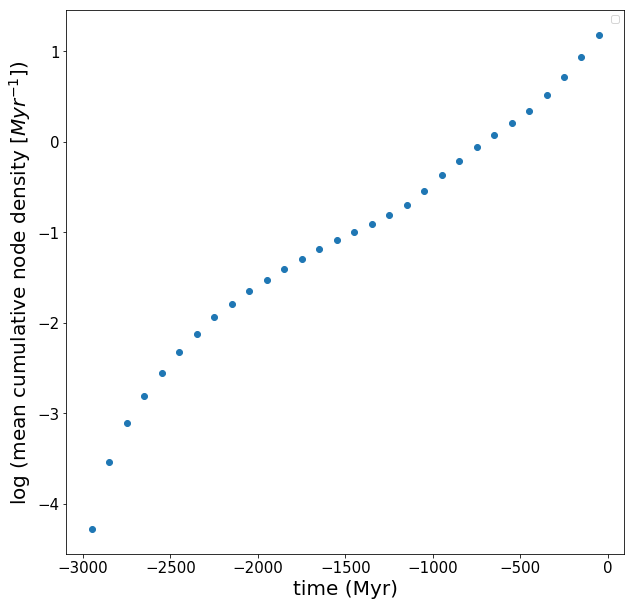

In [33]:
#vectorize f_X, so that it takes arrays and inputs!
g_X_vec = np.vectorize(g_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
#ax.plot(x, g_X_vec(x), color='red', linewidth=3)
ax.plot(array_middle_age_interval_list, log_cumulative_node_density_each_interval_normalized_by_tree_number , 'o')
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('log (mean cumulative node density [$Myr^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('PiecewiseCumulativeLogFitting.jpg.jpg', dpi=500)
plt.show()

In [34]:
# Data here are the slopes using SMA (alos called reduced major axis regresion) in "lmodel2" in R
slope_array_for_cumulative_density = np.array([ 0.006068426, 0.001983296, 0.001087269, 0.001020214, 0.001533947, 0.001962311])

In [35]:
# Data here are the intercepts using SMA (alos called reduced major axis regresion) in "lmodel2" in R
intercept_array_for_cumulative_density = np.array([13.3542217,  2.4397000,  0.5752760,  0.4582104,  1.0714173,  1.2358421])

In [36]:
#definition of the piecewise fitting lines
def g_X(x):
    if x >= array_middle_age_interval_list[0] and x < array_middle_age_interval_list[3]:
        return  x * slope_array_for_cumulative_density[0]  + intercept_array_for_cumulative_density[0]
    elif x >= array_middle_age_interval_list[3] and x < array_middle_age_interval_list[9]:
        return  x * slope_array_for_cumulative_density[1]  + intercept_array_for_cumulative_density[1]
    elif x >= array_middle_age_interval_list[9] and x < array_middle_age_interval_list[15]:
        return  x * slope_array_for_cumulative_density[2]  + intercept_array_for_cumulative_density[2]
    elif x >= array_middle_age_interval_list[15] and x < array_middle_age_interval_list[18]:
        return  x * slope_array_for_cumulative_density[3]  + intercept_array_for_cumulative_density[3]
    elif x >= array_middle_age_interval_list[18] and x < array_middle_age_interval_list[24]:
        return  x * slope_array_for_cumulative_density[4]  + intercept_array_for_cumulative_density[4]
    elif x >= array_middle_age_interval_list[24] and x < array_middle_age_interval_list[29]:
        return  x * slope_array_for_cumulative_density[5]  + intercept_array_for_cumulative_density[5]
    else:
        pass

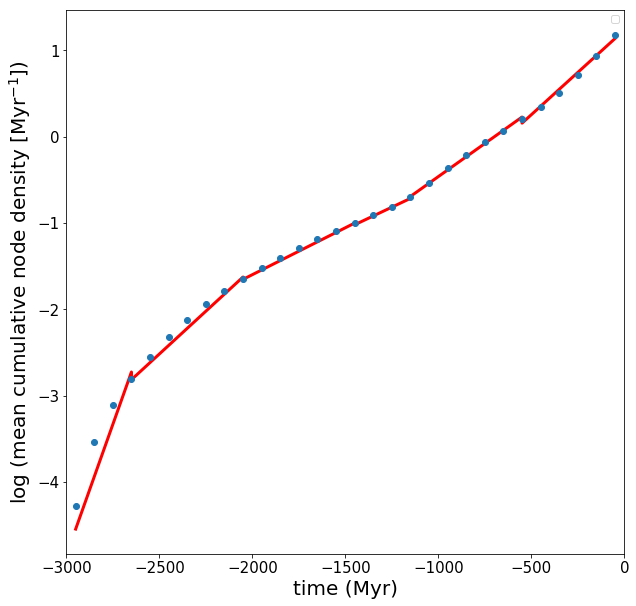

In [31]:
#vectorize f_X, so that it takes arrays and inputs!
g_X_vec = np.vectorize(g_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 100000)
ax.plot(x, g_X_vec(x), color='red', linewidth=3)
ax.plot(array_middle_age_interval_list, log_cumulative_node_density_each_interval_normalized_by_tree_number, 'o')
plt.xlabel('time (Myr)',  size = '20')
plt.xlim(-3000, 0)
plt.ylabel('log (mean cumulative node density [Myr$^{-1}$])', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.yscale('log', basey= 10)
plt.savefig('PiecewiseCumulativeLogFitting.jpg.jpg', dpi=500)
plt.show()

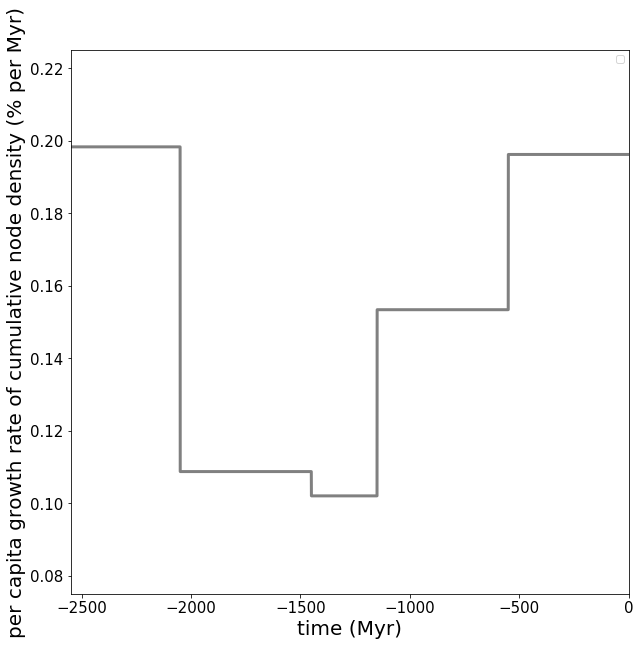

In [32]:
#definition of the pdf
def f_X(x):
    if x >= array_middle_age_interval_list[0] and x < array_middle_age_interval_list[3]:
        return slope_array_for_cumulative_density[0]
    elif x >= array_middle_age_interval_list[3] and x <= array_middle_age_interval_list[9]:
        return slope_array_for_cumulative_density[1]
    elif x >= array_middle_age_interval_list[9] and x <= array_middle_age_interval_list[15]:
        return slope_array_for_cumulative_density[2]
    elif x >= array_middle_age_interval_list[15] and x <= array_middle_age_interval_list[18]:
        return slope_array_for_cumulative_density[3]
    elif x >= array_middle_age_interval_list[18] and x <= array_middle_age_interval_list[24]:
        return slope_array_for_cumulative_density[4]
    else:
        return slope_array_for_cumulative_density[5]


#vectorize f_X, so that it takes arrays and inputs!
f_X_vec = np.vectorize(f_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(min(array_middle_age_interval_list), 0 , 5000)
ax.plot(x, 100*f_X_vec(x), color='gray', linewidth=3)
plt.xlabel('time (Myr)',  size = '20')
plt.ylabel('per capita growth rate of cumulative node density (% per Myr)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(-2550, 0)
plt.ylim(0.075, 0.225)
plt.legend()

#plt.yscale('log', basey= 10)
plt.savefig('GrowthofCumulativeLogNodeNumbers.jpg', dpi=500)
plt.show()

### Comparison between theoretical (per capita) and real node density -- non-cumulative 

In [33]:
# Since the middle_age_interval_list is from -2950 Ma to -50 Ma, we need to reserve it and change it to negative numbers
reverse_middle_age_interval_list = middle_age_interval_list[::-1]
positive_reverse_middle_age_interval_list = [(-1)*i for i in reverse_middle_age_interval_list] 

In [34]:
# Notice that we use (middle_age-50) instead of middle_age as the time, because we started from 50 Ma instead of 0 Ma
theoretical_noncumulative_node_number = [node_number_each_interval_normalized_by_tree_number[0] * np.exp(noncumulative_density_avergae_omega * (middle_age-50)) for middle_age in positive_reverse_middle_age_interval_list]

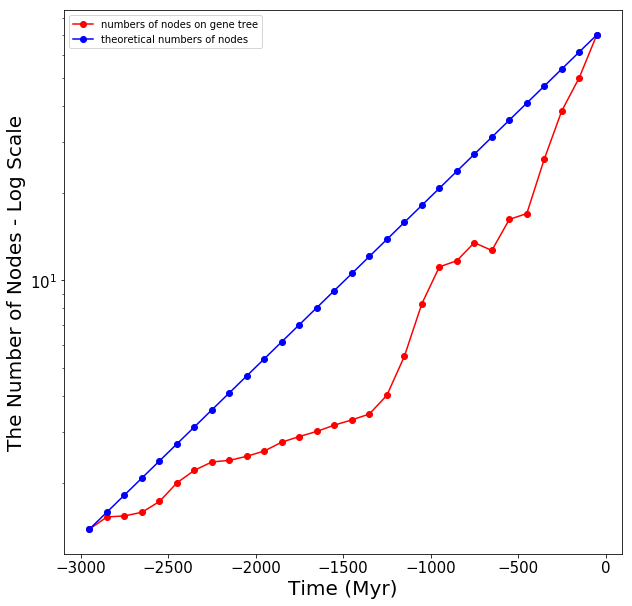

In [35]:
plt.figure(figsize=(10,10))
plt.plot(middle_age_interval_list, node_number_each_interval_normalized_by_tree_number, '-o', color = "red", label="numbers of nodes on gene tree")
plt.plot(middle_age_interval_list, theoretical_noncumulative_node_number, '-o', color ="blue", label= "theoretical numbers of nodes")
plt.xlabel('Time (Myr)',  size = '20')
plt.ylabel('The Number of Nodes - Log Scale', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.yscale('log', basey= 10)
plt.savefig('TheDensityofNonCumulativeNodes.jpg', dpi=300)
plt.show()

### Comparison between theoretical (per capita) and real node density -- cumulative 

In [36]:
# Since the middle_age_interval_list is from -2950 Ma to -50 Ma, we need to reserve it and change it to negative numbers
reverse_middle_age_interval_list = middle_age_interval_list[::-1]
positive_reverse_middle_age_interval_list = [(-1)*i for i in reverse_middle_age_interval_list] 

In [37]:
# Notice that we use (middle_age-50) instead of middle_age as the time, because we started from 50 Ma instead of 0 Ma
theoretical_cumulative_node_number = [cumulative_node_number_each_interval_normalized_by_tree_number[0] * np.exp(cumulative_density_avergae_omega * (middle_age-50)) for middle_age in positive_reverse_middle_age_interval_list]

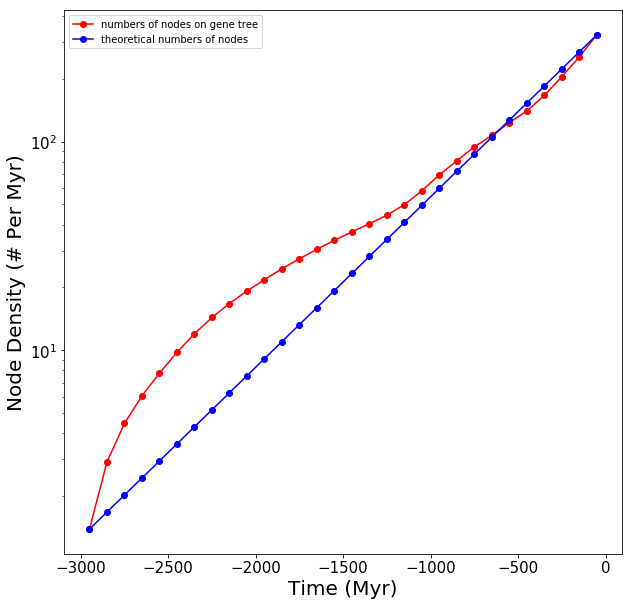

In [38]:
plt.figure(figsize=(10,10))
plt.plot(middle_age_interval_list, cumulative_node_number_each_interval_normalized_by_tree_number, '-o', color = "red", label="numbers of nodes on gene tree")
plt.plot(middle_age_interval_list, theoretical_cumulative_node_number , '-o', color ="blue", label= "theoretical numbers of nodes")
plt.xlabel('Time (Myr)',  size = '20')
plt.ylabel('Node Density (# Per Myr)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.yscale('log', basey= 10)
plt.savefig('TheNodeDensity.jpg', dpi=300)
plt.show()

In [39]:
plt.figure(figsize=(10,10))
plt.plot(middle_age_interval_list, normalized_node_density_list_normalized_by_tree_number , '-o')
plt.xlabel('Time (Ma)',  size = '20')
plt.ylabel('Normalized Node Density (unitless)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim = [0.01, 10]
#plt.yscale('log', basey= 10)
plt.savefig('Normalized Node Density Distribution.jpg', dpi=300)
plt.show()

NameError: name 'normalized_node_density_list_normalized_by_tree_number' is not defined

<Figure size 720x720 with 0 Axes>

### Divergence Rate at time $t$ Based ONLY on Previous Time $(t-1)$ (NOT Cumulative but with Log)

TypeError: 'list' object is not callable

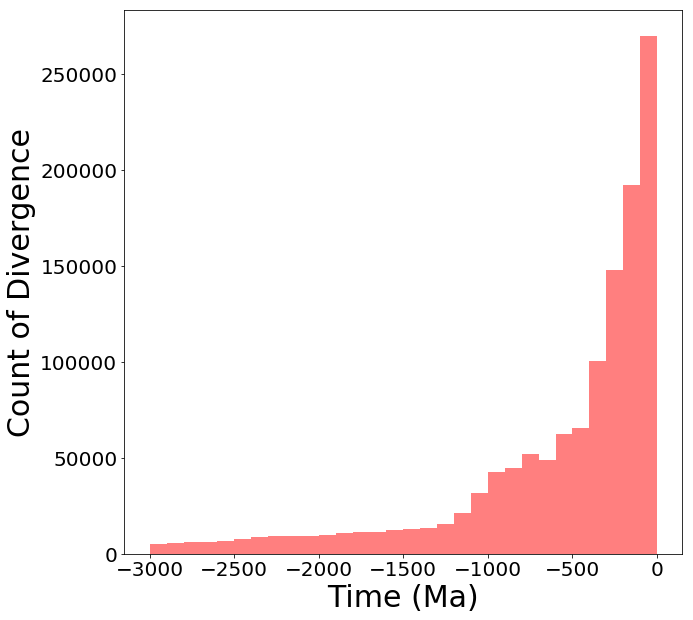

In [724]:
# histogram of node numbers (NOT cumulative number)

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(negative_age_list_1, 3000/bin_size, range = (-3000, 0), facecolor='red', alpha=0.5)
plt.xlabel('Time (Ma)',  size = '30')
plt.ylabel('Count of Divergence',  size = '30')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(-3000, 100)
plt.yscale('log')
plt.yscale('log', basey=10)
plt.show()

In [563]:
# Treat the node number sequences as time series x(t).
# For x(t), we need to delete first element in the node number list
time_t_node_number_each_interval = [node_number_each_interval_normalized_by_tree_number[index] for index in range(1, len(node_number_each_interval_normalized_by_tree_number))]

# For x(t-1), we need to delete the last element in the node number list
time_t_minus_one_node_number_each_interval = [node_number_each_interval_normalized_by_tree_number[index] for index in range(0, len(node_number_each_interval_normalized_by_tree_number)-1)]

# Compute the "per capita divergence per gene per Myr" with based ONLY on one previous node number 
# and put them into a list.
divergence_rate_NON_cumulative = [(np.log(x)-np.log(y)) / float(bin_size) for x, y in zip(time_t_node_number_each_interval, time_t_minus_one_node_number_each_interval)]

In [565]:
# The time list (middle age list) should be moved unit unit (one bin size) to the right, which is equivalent ot
# delete the first element in the time list
new_middle_age_interval_list = [middle_age_interval_list[index] for index in range(1, len(middle_age_interval_list))]

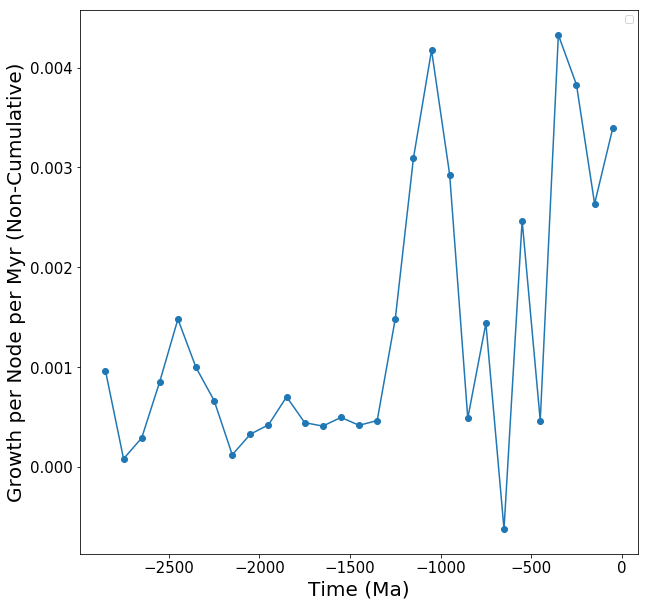

In [566]:
plt.figure(figsize=(10,10))
plt.plot(new_middle_age_interval_list, divergence_rate_NON_cumulative, '-o')
plt.xlabel('Time (Ma)',  size = '20')
plt.ylabel('Growth per Node per Myr (Non-Cumulative)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
#plt.xlim(-3000, 0)
plt.savefig('Growth Rate of Node Number (Non-Cumulative)', dpi=500)
plt.show()

### Divergence Rate at time $t$ Based ONLY on Previous Time $(t-1)$ (NOT Cumulative and without Log)

In [424]:
(time_t_node_number_each_interval[1]- time_t_minus_one_node_number_each_interval[1])/ float(time_t_node_number_each_interval[1]*bin_size)

0.0005007363770250335

In [422]:
(np.log(time_t_node_number_each_interval[1]) - np.log(time_t_minus_one_node_number_each_interval[1]))/ float(bin_size)

0.0005038969934785165

In [423]:
divergencewithout_log_rate_NON_cumulative[1]

0.0005070842654735238

In [420]:
# Treat the node number sequences as time series x(t).
# For x(t), we need to delete first element in the node number list
time_t_node_number_each_interval = [node_number_each_interval_normalized_by_tree_number[index] for index in range(1, len(node_number_each_interval_normalized_by_tree_number))]

# For x(t-1), we need to delete the last element in the node number list
time_t_minus_one_node_number_each_interval = [node_number_each_interval_normalized_by_tree_number[index] for index in range(0, len(node_number_each_interval_normalized_by_tree_number)-1)]

# Compute the "per capita divergence per gene per Myr" with based ONLY on one previous node number 
# and put them into a list.
divergencewithout_log_rate_NON_cumulative = [(x-y) / float(y *bin_size) for x, y in zip(time_t_node_number_each_interval, time_t_minus_one_node_number_each_interval)]

In [416]:
# The time list (middle age list) should be moved unit unit (one bin size) to the right, which is equivalent ot
# delete the first element in the time list
new_middle_age_interval_list = [middle_age_interval_list[index] for index in range(1, len(middle_age_interval_list))]

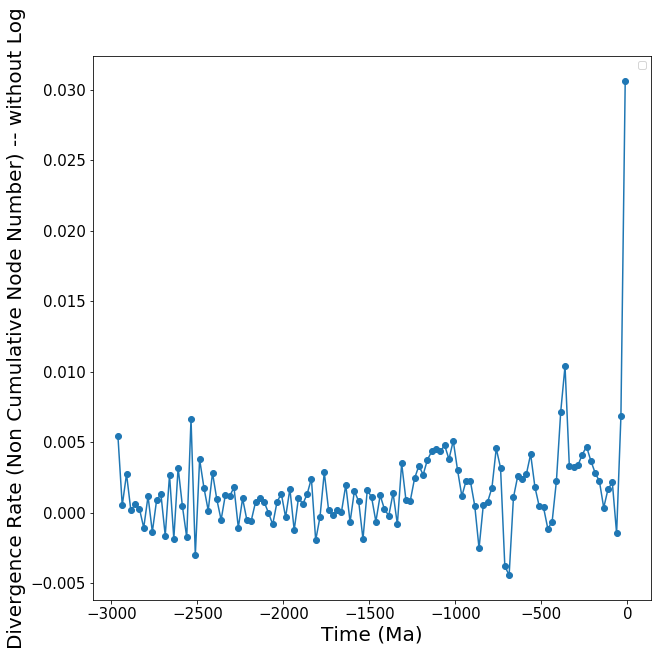

In [419]:
plt.figure(figsize=(10,10))
plt.plot(new_middle_age_interval_list, divergencewithout_log_rate_NON_cumulative, '-o')
plt.xlabel('Time (Ma)',  size = '20')
plt.ylabel('Divergence Rate (Non Cumulative Node Number) -- without Log', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.savefig('Growth Rate of Node Number (Non Cumulative Node Number and without Log).jpg', dpi=300)
plt.show()

### Divergence Rate at time $t$ Based on Cumulative Number of Nodes

In [430]:
df_1 = df
df_list_1  = df_1[0:3839]
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])
his_data_eight_calibration_1 = np.histogram(negative_age_list_1, bins=3000/bin_size, range = (-3000, 0))

Divergence_number_in_bin_eight_calibration = his_data_eight_calibration_1[0]

# Calculate cumulative number of nodes
cumulative_divergence_number = np.cumsum(Divergence_number_in_bin_eight_calibration) 
cumulative_divergence_number = cumulative_divergence_number.tolist()

In [587]:
difference_cumulative_number_list= []
for cumulative_number_index in range(1, len(cumulative_divergence_number)):
    cumulative_divergence_t = cumulative_divergence_number[cumulative_number_index]
    cumulative_divergence_t_minus_1 = cumulative_divergence_number[cumulative_number_index - 1]
    difference_cumulative_number = (cumulative_divergence_t - cumulative_divergence_t_minus_1) / float(cumulative_divergence_t_minus_1)
    difference_cumulative_number_list.append(difference_cumulative_number)
len(difference_cumulative_number_list)

119

In [429]:
difference_cumulative_number_list

NameError: name 'difference_cumulative_number_list' is not defined

In [588]:
#cumulative_divergence_number

In [589]:
age_interval_list =  his_data_eight_calibration_1[1].tolist()
first_age_interval_list = [age_interval_list[i] for i  in range(0, len(age_interval_list)-1)]
second_age_interval_list = [age_interval_list[i] for i in range(1, len(age_interval_list))]
middle_age_each_bin_eight_calibration = [(a + b) / 2 +bin_size for a, b in zip(first_age_interval_list, second_age_interval_list)]
del middle_age_each_bin_eight_calibration[-1]
len(middle_age_each_bin_eight_calibration)

119

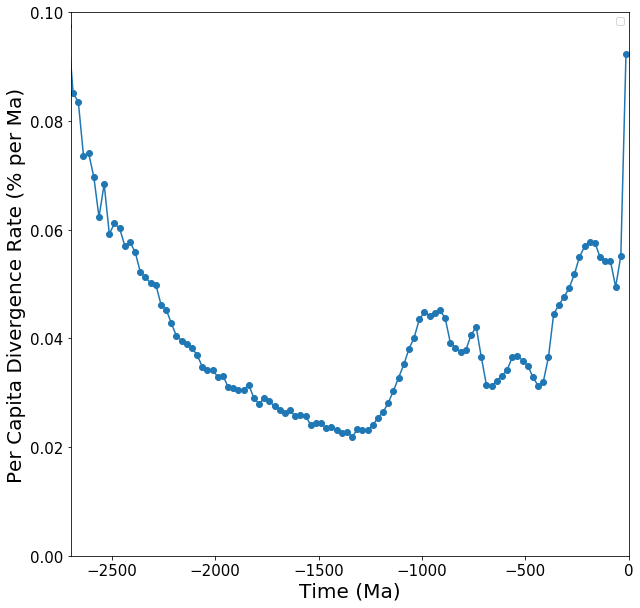

In [594]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration, difference_cumulative_number_list, '-o')
plt.xlabel('Time (Ma)',  size = '20')
plt.ylabel('Per Capita Divergence Rate (% per Ma)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(0, 0.1)
plt.xlim(-2700, 0)
plt.show()

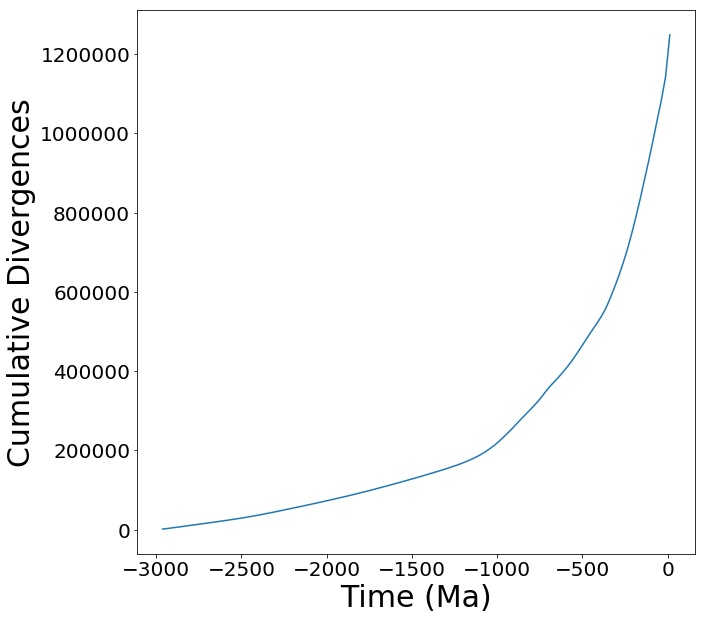

In [529]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration, cumulative_divergence_number)
plt.xlabel('Time (Ma)',  size = '30')
plt.ylabel('Cumulative Divergences',  size = '30')
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.yscale('log', basey=np.e)
plt.show()

In [448]:
cumulative_divergence_number

array([   2522,    5330,    8265,   11200,   14128,   17118,   20125,
         23206,   26370,   29841,   33573,   37535,   41701,   46036,
         50567,   55119,   59616,   64315,   69008,   73816,   78768,
         83726,   88910,   94359,   99817,  105475,  111148,  117053,
        123190,  129215,  135476,  141898,  148414,  155184,  162469,
        170599,  180043,  191596,  205890,  223472,  243800,  266197,
        288735,  311056,  335926,  362861,  385918,  411540,  441166,
        473833,  506503,  539075,  583654,  639636,  705893,  787103,
        880404,  979059, 1083158, 1248505])

In [419]:
difference_cumulative_number_list= []
for cumulative_number_index in range(1, len(cumulative_divergence_number)):
    cumulative_divergence_t = cumulative_divergence_number[cumulative_number_index]
    cumulative_divergence_t_minus_1 = cumulative_divergence_number[cumulative_number_index - 1]
    difference_cumulative_number = np.log(cumulative_divergence_t) - np.log(cumulative_divergence_t_minus_1)
    difference_cumulative_number_list.append(difference_cumulative_number)
len(difference_cumulative_number_list)

59

In [447]:
difference_cumulative_number_list

[0.7482990006350256,
 0.4386784930952352,
 0.3038840470280597,
 0.23224486556055624,
 0.19197189759781352,
 0.16183228184520893,
 0.1424480426207264,
 0.12781613443984163,
 0.12365628647319227,
 0.11783888566561274,
 0.11155165852096616,
 0.10525127830760184,
 0.09889858977367716,
 0.09387549051621669,
 0.08619529468324671,
 0.07842951011346955,
 0.07586889111150086,
 0.07042955437480813,
 0.06735307037076765,
 0.0649313127395903,
 0.06104273945693528,
 0.06007505966026727,
 0.059482034639376735,
 0.05623185272003006,
 0.05513544851794805,
 0.05238868853571077,
 0.05176417713498083,
 0.05110105529278819,
 0.04774980470685186,
 0.0473168191798905,
 0.046313986773345306,
 0.044897176272248984,
 0.0446058437449679,
 0.045875704689072094,
 0.04882855903542804,
 0.053879937874006245,
 0.06219327724242163,
 0.07195305709653788,
 0.08194408097476291,
 0.08706209048375513,
 0.08788841912832268,
 0.08127267625921597,
 0.07446364784357407,
 0.07691793733371277,
 0.07712894321003638,
 0.061605070

In [397]:
def function (his_data_eight_calibration):
    age_interval_list =  his_data_eight_calibration[1].tolist()
    first_age_interval_list = [age_interval_list[i] for i  in range(0, len(age_interval_list)-1)]
    second_age_interval_list = [age_interval_list[i] for i in range(1, len(age_interval_list))]
    middle_age_each_bin_eight_calibration = [(a + b) / 2 for a, b in zip(first_age_interval_list, second_age_interval_list)]
    Divergence_number_in_bin_eight_calibration = his_data_eight_calibration[0]
    
    
    cumulative_divergence_number = np.cumsum(Divergence_number_in_bin_eight_calibration)
    new_cumulative_divergence_number = cumulative_divergence_number.tolist()
    del new_cumulative_divergence_number[len(new_cumulative_divergence_number)-1]
    del new_cumulative_divergence_number[0]
    
   # del middle_age_each_bin_eight_calibration[len(middle_age_each_bin_eight_calibration)-1]
    del middle_age_each_bin_eight_calibration[0]
    
    difference_cumulative_number_list= []
    for cumulative_number_index in range(1, len(cumulative_divergence_number)):
        cumulative_divergence_t = cumulative_divergence_number[cumulative_number_index]
        cumulative_divergence_t_minus_1 = cumulative_divergence_number[cumulative_number_index - 1]
        difference_cumulative_number = np.log(cumulative_divergence_t) - np.log(cumulative_divergence_t_minus_1)
        difference_cumulative_number_list.append(difference_cumulative_number)
        
    rate_list = difference_cumulative_number_list
    difference_age = bin_size
    rate_list = [ i/float(difference_age) for i in difference_cumulative_number_list]
    
    percentgae_version_rate_list = [i * 100 for i in rate_list]
    
    return middle_age_each_bin_eight_calibration, percentgae_version_rate_list

In [398]:
df_1 = df
df_list_1  = df_1[0:3839]
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])
his_data_eight_calibration_1 = np.histogram(negative_age_list_1, bins=3000/bin_size, range = (-3000, 0))

In [399]:
len(negative_age_list_1)

1263031

In [400]:
his_data_eight_calibration_1 

(array([  2522,   2808,   2935,   2935,   2928,   2990,   3007,   3081,
          3164,   3471,   3732,   3962,   4166,   4335,   4531,   4552,
          4497,   4699,   4693,   4808,   4952,   4958,   5184,   5449,
          5458,   5658,   5673,   5905,   6137,   6025,   6261,   6422,
          6516,   6770,   7285,   8130,   9444,  11553,  14294,  17582,
         20328,  22397,  22538,  22321,  24870,  26935,  23057,  25622,
         29626,  32667,  32670,  32572,  44579,  55982,  66257,  81210,
         93301,  98655, 104099, 165347]),
 array([-3000., -2950., -2900., -2850., -2800., -2750., -2700., -2650.,
        -2600., -2550., -2500., -2450., -2400., -2350., -2300., -2250.,
        -2200., -2150., -2100., -2050., -2000., -1950., -1900., -1850.,
        -1800., -1750., -1700., -1650., -1600., -1550., -1500., -1450.,
        -1400., -1350., -1300., -1250., -1200., -1150., -1100., -1050.,
        -1000.,  -950.,  -900.,  -850.,  -800.,  -750.,  -700.,  -650.,
         -600.,  -550.

In [401]:
middle_age_each_bin_eight_calibration_1, percentgae_version_rate_list_1 = function (his_data_eight_calibration_1)

In [409]:
percentgae_version_rate_list_1 

[1.4965980012700513,
 0.8773569861904704,
 0.6077680940561194,
 0.46448973112111247,
 0.38394379519562705,
 0.32366456369041785,
 0.2848960852414528,
 0.25563226887968327,
 0.24731257294638453,
 0.23567777133122547,
 0.22310331704193231,
 0.21050255661520367,
 0.19779717954735432,
 0.18775098103243337,
 0.17239058936649343,
 0.1568590202269391,
 0.15173778222300172,
 0.14085910874961627,
 0.1347061407415353,
 0.1298626254791806,
 0.12208547891387055,
 0.12015011932053454,
 0.11896406927875347,
 0.11246370544006011,
 0.1102708970358961,
 0.10477737707142154,
 0.10352835426996165,
 0.10220211058557638,
 0.09549960941370372,
 0.094633638359781,
 0.09262797354669061,
 0.08979435254449797,
 0.0892116874899358,
 0.09175140937814419,
 0.09765711807085609,
 0.1077598757480125,
 0.12438655448484327,
 0.14390611419307575,
 0.16388816194952582,
 0.17412418096751026,
 0.17577683825664536,
 0.16254535251843194,
 0.14892729568714813,
 0.15383587466742554,
 0.15425788642007277,
 0.12321014168415445,


In [403]:
middle_age_each_bin_eight_calibration_1, percentgae_version_rate_list_1 = function (his_data_eight_calibration_1)
percentgae_version_rate_list_std_1 = percentgae_version_rate_list_1

In [404]:
len(negative_age_list_1)

1263031

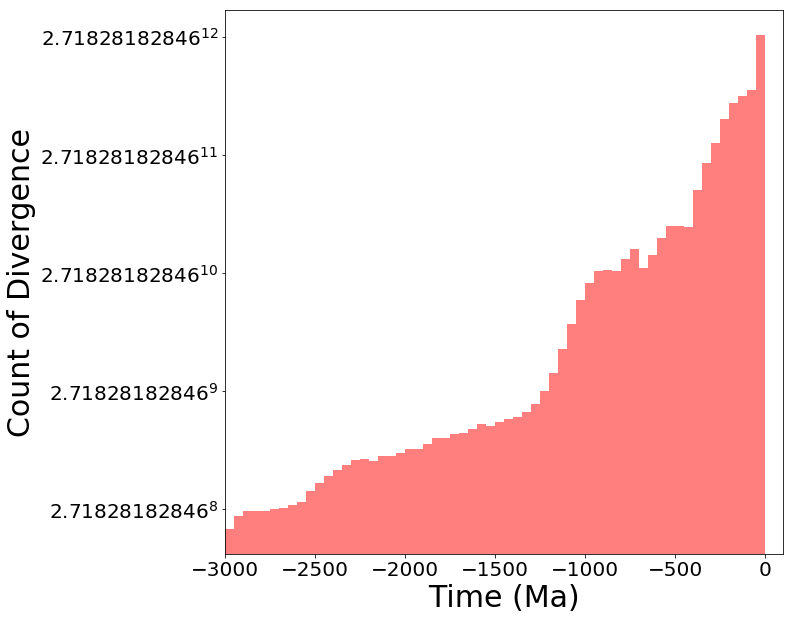

In [490]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
bin_size = 25
n, bins, patches = plt.hist(negative_age_list_1, 3000/50, range = (-3000, 0), facecolor='red', alpha=0.5)
plt.xlabel('Time (Ma)',  size = '30')
plt.ylabel('Count of Divergence',  size = '30')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(-3000, 100)
plt.yscale('log')
plt.yscale('log', basey=np.e)
plt.show()

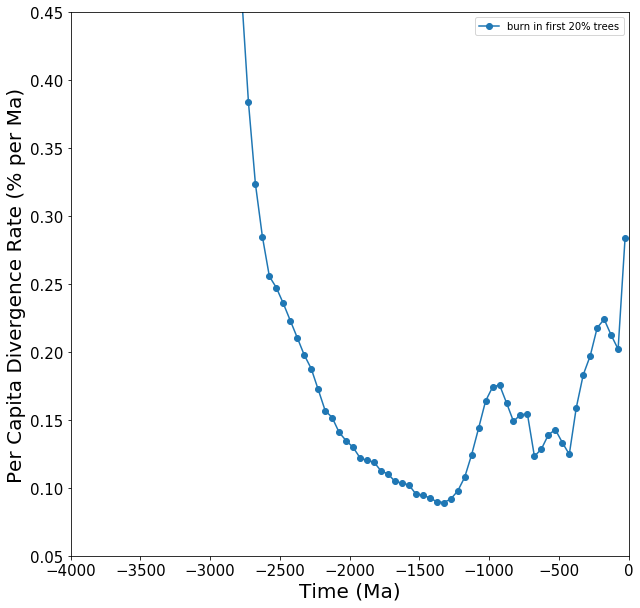

In [514]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration_1, percentgae_version_rate_list_1,  '-o', label='burn in first 20% trees')
plt.xlabel('Time (Ma)',  size = '20')
plt.ylabel('Per Capita Divergence Rate (% per Ma)', size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(0.05, 0.45)
plt.xlim(-4000, 0)
plt.show()

In [322]:
bin_size = bin_size
All_percentgae_version_rate_list = []
for tree_sample_index in range(940 , 4699):
    df_list_1  = df_1.iloc[tree_sample_index,:]
    df_list_1 = df_list_1.values.tolist()
    cleaned_df_list_1 = [x for x in df_list_1 if str(x) != 'nan']
    negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])
    his_data_eight_calibration_1_new = np.histogram(negative_age_list_1, bins=3500/bin_size, range = (-3500, 0))
    middle_age_each_bin_eight_calibration_1_new, percentgae_version_rate_list_1_new = function (his_data_eight_calibration_1_new)
    All_percentgae_version_rate_list.append(percentgae_version_rate_list_1_new)
All_percentgae_version_rate_dataframe = pd.DataFrame(All_percentgae_version_rate_list)

TypeError: bad operand type for unary -: 'str'

In [692]:
All_percentgae_version_rate_dataframe = All_percentgae_version_rate_dataframe.replace([np.inf, -np.inf, np.nan], 0)

In [693]:
mean_list = []
for node_index in range(0, All_percentgae_version_rate_dataframe.shape[1]):
    rate_list_at_a_node = list(All_percentgae_version_rate_dataframe.iloc[:,node_index])
    mean_at_a_node = np.mean(np.asarray(rate_list_at_a_node))
    mean_list.append(mean_at_a_node)

In [694]:
std_list = []
for node_index in range(0, All_percentgae_version_rate_dataframe.shape[1]):
    rate_list_at_a_node = list(All_percentgae_version_rate_dataframe.iloc[:,node_index])
    std_at_a_node = np.std(np.asarray(rate_list_at_a_node))
    std_list.append(std_at_a_node)

In [695]:
mean_std_list = [i/np.sqrt(4699-940+1) for i in std_list]

In [696]:
median_list = []
for node_index in range(0, All_percentgae_version_rate_dataframe.shape[1]):
    rate_list_at_a_node = list(All_percentgae_version_rate_dataframe.iloc[:,node_index])
    median_at_a_node = np.median(np.asarray(rate_list_at_a_node))
    median_list.append(median_at_a_node)

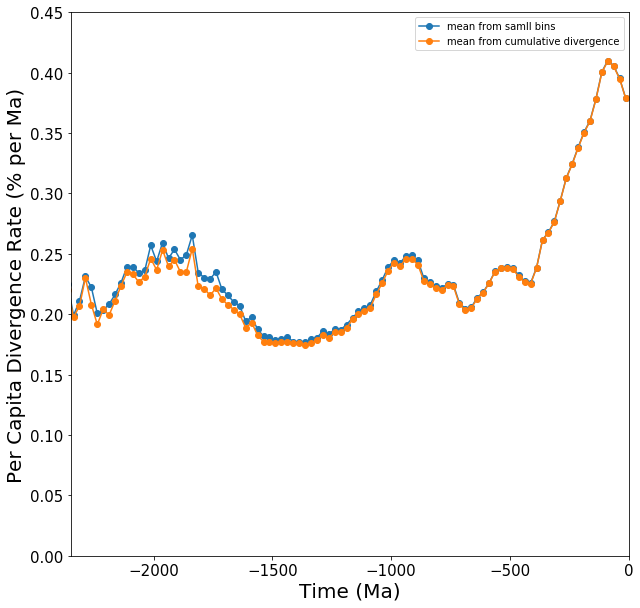

In [697]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration_1, mean_list,  '-o', label='mean from samll bins')
plt.plot(middle_age_each_bin_eight_calibration_1, percentgae_version_rate_list_1,  '-o', label='mean from cumulative divergence')
plt.ylabel('Per Capita Divergence Rate (% per Ma)',  size = '20')
plt.xlabel('Time (Ma)',  size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(1, 0.45)
plt.xlim(-2350, 0)
plt.show()

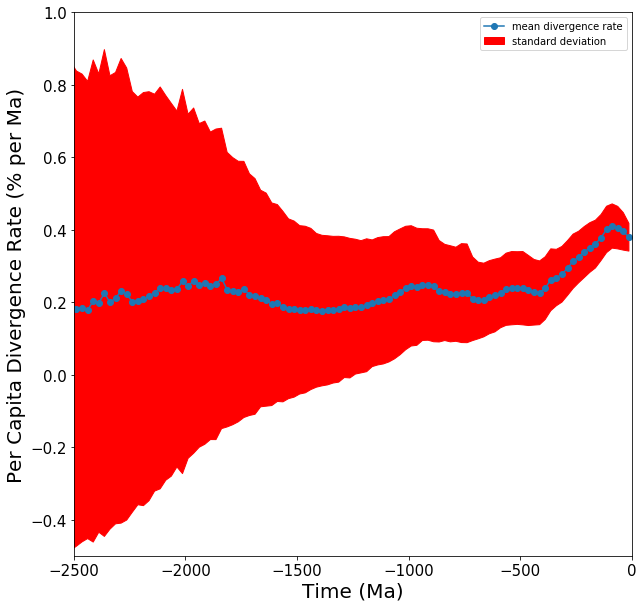

In [700]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
positive_std_list = [(a + b) for a, b in zip(mean_list, std_list)]
negative_std_list = [(a - b) for a, b in zip(mean_list, std_list)]
plt.plot(middle_age_each_bin_eight_calibration_1, mean_list, '-o', label='mean divergence rate')
plt.fill_between(middle_age_each_bin_eight_calibration_1, positive_std_list, 
                 negative_std_list, color='red', label='standard deviation') 
plt.ylabel('Per Capita Divergence Rate (% per Ma)',  size = '20')
plt.xlabel('Time (Ma)',  size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(-2500, 0)
plt.show()

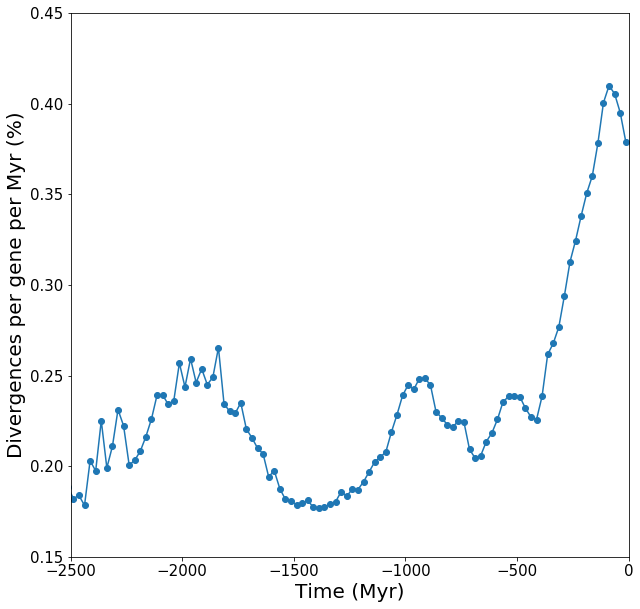

In [733]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(10,10))
#mean_divided_by_100_list = [i / float(100) for i in mean_list]
positive_std_mean_list = [(a + b) for a, b in zip(mean_list, mean_std_list)]
negative_std_mean_list = [(a - b) for a, b in zip(mean_list, mean_std_list)]
plt.plot(middle_age_each_bin_eight_calibration_1, mean_list, '-o', label='mean divergence rate')
#plt.fill_between(middle_age_each_bin_eight_calibration_1, positive_std_mean_list, 
#                 negative_std_mean_list, color='red', label='mean deviation') 
plt.ylabel('Divergences per gene per Myr (%)',  size = '20')
plt.xlabel('Time (Myr)',  size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.legend()
plt.ylim(0.15, 0.45)
plt.xlim(-2500, 0)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('filename.png', dpi=500)
plt.show()


In [702]:
# Calculate the 95% confidence interval in each bin
predictive_interval_lower_list = []
predictive_interval_upper_list = []
for node_index in range(0, All_percentgae_version_rate_dataframe.shape[1]):
    rate_list_at_a_node = list(All_percentgae_version_rate_dataframe.iloc[:,node_index])
    predicted_value_left = np.percentile(rate_list_at_a_node, 5)
    predicted_value_right = np.percentile(rate_list_at_a_node, 95)
    predictive_interval_lower_list.append(predicted_value_left)
    predictive_interval_upper_list.append(predicted_value_right)

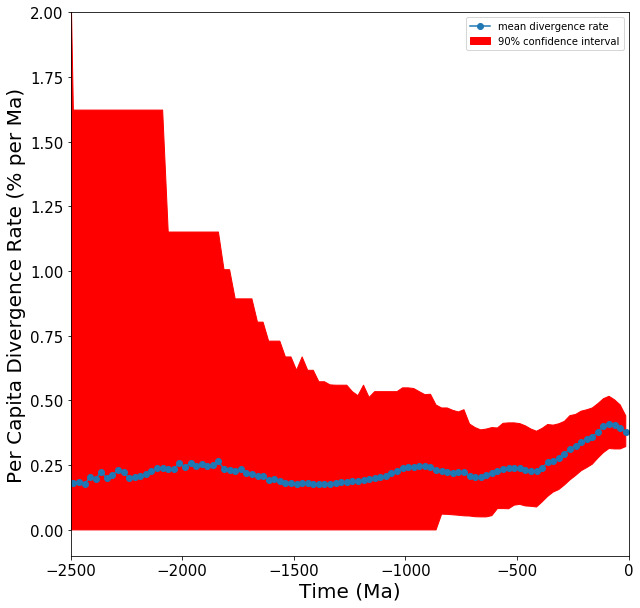

In [709]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration_1, mean_list, '-o', label='mean divergence rate')
plt.fill_between(middle_age_each_bin_eight_calibration_1, predictive_interval_lower_list, 
                 predictive_interval_upper_list, color='red', label='90% confidence interval') 
plt.ylabel('Per Capita Divergence Rate (% per Ma)',  size = '20')
plt.xlabel('Time (Ma)',  size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(-0.1, 2)
plt.xlim(-2500, 0)
plt.show()

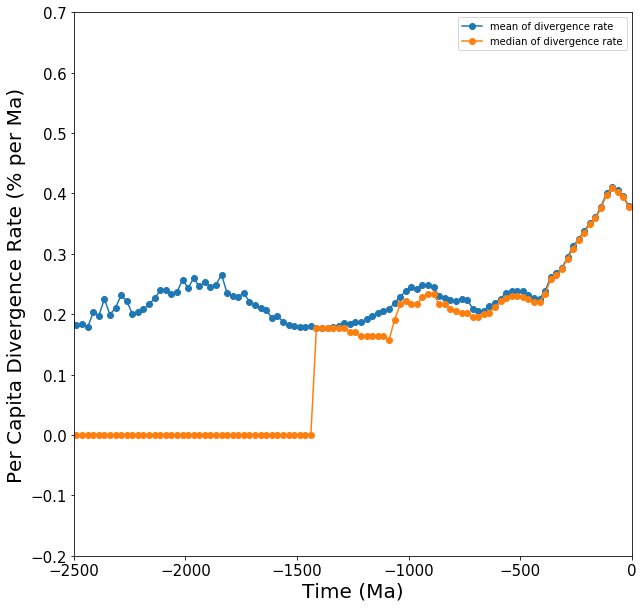

In [711]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(middle_age_each_bin_eight_calibration_1, mean_list, '-o', label='mean of divergence rate')
plt.plot(middle_age_each_bin_eight_calibration_1, median_list, '-o', label='median of divergence rate') 
plt.ylabel('Per Capita Divergence Rate (% per Ma)',  size = '20')
plt.xlabel('Time (Ma)',  size = '20')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.ylim(-0.2, 0.7)
plt.xlim(-2500, 0)
plt.show()